# "kNN & Linear Regression From Scratch: Iris Dataset"
> A step-by-step implementation of the k-Nearest Neighbours and Linear Regression algorithms using just the standard Python libaries.

- toc: true
- author: Oluwaleke Umar Yusuf
- badges: true
- comments: true
- image: images/ipynb/iris_dataset.png
- hide: false
- search_exclude: false
- categories: [notebook]
- tags: [kNN, Iris Dataset]

# kNN & Linear Regression From Scratch: Iris Dataset

> Note: You can skip over the **Introduction** section. Jump to **[k-Nearest Neighbours implementation](#k-nearest-neighbours-from-scratch)**.

---

# Introduction


## Iris Dataset

The [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) is perhaps the best known database to be found in the pattern recognition literature.

The data set (available [here](https://www.kaggle.com/uciml/iris)) consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. **One class (specie) is linearly separable from the other 2; the latter are NOT linearly separable from each other, as seen in the plots below.**

<div align="center">

<a title="Credit: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html"><img align="center" src="https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_dataset_001.png " style="height:250px;" /></a>&nbsp;
<a title="Credit: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html"><img align="center" src="https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_dataset_002.png " style="height:250px;" />

</div>&nbsp;

## k-Nearest Neighbours Algorithm

The [k-Nearest Neighbours](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) algorithm is a non-parametric classification method used for classification and regression. In kNN classification, an object being assigned to the class most common among its `k` nearest neighbors (k is a positive integer, typically small). If `k = 1`, then the object is simply assigned to the class of that single nearest neighbor.

![k-Nearest Neighbours](https://i.ibb.co/VQMh7p4/knn.png "Credit: http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/KNN_final1_ibdm8a.png")&nbsp;

> Info: Jump to **[k-Nearest Neighbours implementation](#k-nearest-neighbours-from-scratch)**.

<br/>

## Linear Regression Algorithm

The [Linear Regression](https://en.wikipedia.org/wiki/Linear_regression) algorithm is a linear approach to modelling the relationship between a scalar response (y — dependent variables) and one or more explanatory variables (X — independent variables). Linear Regression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

<a title="Credit: https://wiki.aalto.fi/display/ITSP/Linear+regression"><img align="center" src="https://wiki.aalto.fi/download/attachments/155464048/linreg.png?version=1&modificationDate=1565612055936&api=v2 " style="height:300px;" />


> Info: Jump to **[Linear Regression implementation](#linear-regression-from-scratch)**.

---

In [23]:
# importing required libraries
import random
import csv
import math
import statistics
import copy

# set ramdom seed
random.seed('iris dataset')

---

# k-Nearest Neighbours From Scratch

The flowchart for implementing the kNN algorithm is shown below. Each step in the implementation will be wrapped in its own function for clarity.

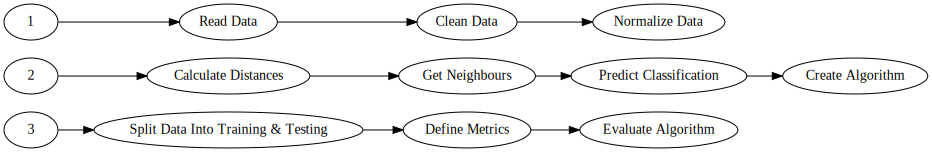

In [24]:
#hide_input
from fastbook import gv

gv(
'''
3->"Split Data Into Training & Testing"->"Define Metrics"->"Evaluate Algorithm"
2->"Calculate Distances"->"Get Neighbours"->"Predict Classification"->"Create Algorithm"
1->"Read Data"->"Clean Data"->"Normalize Data"
'''
)

### The dataset is contained in .csv file. We will implement a main function `DataLoader` that calls several child functions. 

## Read Data

We start with the `_load_csv()` function which will use the python [csv](https://docs.python.org/3/library/csv.html) module to read the file contents.

In [25]:
#collapse-output
def _load_csv(filename):
	with open(filename, 'r') as file:
		csv_reader = csv.reader(file)
		return [row for row in csv_reader if row]

dataset = _load_csv("ipynb_data/IrisData.csv")
dataset[:2]+dataset[51:53]+dataset[-2:]

[['5.1', '3.5', '1.4', '0.2', 'Iris-setosa'],
 ['4.9', '3.0', '1.4', '0.2', 'Iris-setosa'],
 ['6.4', '3.2', '4.5', '1.5', 'Iris-versicolor'],
 ['6.9', '3.1', '4.9', '1.5', 'Iris-versicolor'],
 ['6.2', '3.4', '5.4', '2.3', 'Iris-virginica'],
 ['5.9', '3.0', '5.1', '1.8', 'Iris-virginica']]

## Clean Data

We can see that the csv reader loads the entire dataset as a list of list, each inner list containing `['sepal length', 'sepal width', 'petal length', 'petal width', 'species']`. We need to convert the four features from strings to floats. Let's create a function called `_clean_features()`.

In [26]:
#collapse-output
def _clean_features(dataset):
    num_columns = len(dataset[0])

    for row in dataset:
        for column in range(num_columns-1):
            row[column] = float(row[column].strip())

_clean_features(dataset)
dataset[:2]+dataset[51:53]+dataset[-2:]

[[5.1, 3.5, 1.4, 0.2, 'Iris-setosa'],
 [4.9, 3.0, 1.4, 0.2, 'Iris-setosa'],
 [6.4, 3.2, 4.5, 1.5, 'Iris-versicolor'],
 [6.9, 3.1, 4.9, 1.5, 'Iris-versicolor'],
 [6.2, 3.4, 5.4, 2.3, 'Iris-virginica'],
 [5.9, 3.0, 5.1, 1.8, 'Iris-virginica']]

Furthermore, in machine learning, it is preferred that all data be numeric (floats or integers). Thus, we need convert each unique class values (species) to integer and create a map between the integer values and the actual string values. We'll create a function called `_map_classes()` to acheieve this. 

In [27]:
#collapse-output
def _map_classes(dataset):
    class_mappings = {}
    for row in dataset:
        _specie = row[-1]
        if _specie not in class_mappings.keys():
            class_mappings[_specie] = len(class_mappings)
        row[-1] = class_mappings[_specie]

    return class_mappings

class_mappings = _map_classes(dataset)
print(class_mappings)
dataset[:2]+dataset[51:53]+dataset[-2:]

{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}


[[5.1, 3.5, 1.4, 0.2, 0],
 [4.9, 3.0, 1.4, 0.2, 0],
 [6.4, 3.2, 4.5, 1.5, 1],
 [6.9, 3.1, 4.9, 1.5, 1],
 [6.2, 3.4, 5.4, 2.3, 2],
 [5.9, 3.0, 5.1, 1.8, 2]]

> Note: Now we have successfully cleaned out data and mapped the classes.

<br/>

## Normalize Data

In Machine Learning, two data scaling methods are most commonly discussed: [Normalization](https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization)) and [Standardization](https://en.wikipedia.org/wiki/Feature_scaling#Standardization_(Z-score_Normalization)).

Normalization typically means rescales the values into a range of [0,1]. Standardization typically means rescales data to have a mean of 0 and a standard deviation of 1 (unit variance). This [article](https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf) analyzes the empirical results of applying different scaling methods on features in multiple experiments settings.

Distance-based algorithms (such as kNN) are affected by the scale of the variables and will give higher weightage to variables which have higher magnitude. To prevent the algorithm from being biased towards variables with higher magnitude, we can bring down all the variables to the same scale.

In our case, we will make use of Normalization (also known as min-max scaling) as it limits the range of the data and thus, a better option for kNN. Let's create a function called `_normalize_data()` The Normalization formula is shown below.

<a title="Credit: https://www.kdnuggets.com/2020/04/data-transformation-standardization-normalization.html"><img align="center" src="https://miro.medium.com/max/1400/1*GwcC80mDUyscDAWtwZSBdA.png " style="height:150px;" />

In [28]:
#collapse-output
def _normalize_data(dataset):
    num_features = len(dataset[0])-1
    for i in range(num_features):
        column_values = [row[i] for row in dataset]
        column_min = min(column_values)
        column_max = max(column_values)
        
        for row in dataset:
            row[i] = (row[i] - column_min) / (column_max - column_min)

_normalize_data(dataset)
dataset[:2]+dataset[51:53]+dataset[-2:]

[[0.22222222222222213,
  0.6249999999999999,
  0.06779661016949151,
  0.04166666666666667,
  0],
 [0.1666666666666668,
  0.41666666666666663,
  0.06779661016949151,
  0.04166666666666667,
  0],
 [0.5833333333333334, 0.5, 0.5932203389830508, 0.5833333333333334, 1],
 [0.7222222222222222,
  0.4583333333333333,
  0.6610169491525424,
  0.5833333333333334,
  1],
 [0.5277777777777778,
  0.5833333333333333,
  0.7457627118644068,
  0.9166666666666666,
  2],
 [0.44444444444444453,
  0.41666666666666663,
  0.6949152542372881,
  0.7083333333333334,
  2]]

> Important: Now putting all the child functions together in the main function:

<br/>

In [29]:
def DataLoader(filename):
    dataset = _load_csv(filename)
    _clean_features(dataset)
    class_mappings = _map_classes(dataset)
    _normalize_data(dataset)

    return dataset, class_mappings

### Now, we're done preparing the dataset for the classification using the kNN algorithm. Next, we implement the algorithm itself in a main function `kNN_Algorithm` that calls several child functions.  

## Calculate Euclidean Distances 

We need to create a function that calculates the distance between two sets of data features. THere are different distance formulas availabe but the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) is most commonly used for kNN classification problems.  

In mathematics, the Euclidean distance between two points in Euclidean space is the length of a line segment between the two points. The formula is shown below and is implemented with the `_euclidean_distance()` function.

![Euclidean Distance Formula](https://aws1.discourse-cdn.com/codecademy/original/5X/e/2/9/6/e296139537a35d53394033117a05f12a401d4c42.png "Credit: https://discuss.codecademy.com/t/faq-distance-formula-euclidean-distance/374303")

In [30]:
#collapse-output
def _euclidean_distance(row1, row2):
    distance = 0.0
    num_features = len(row1)-1

    for i in range(num_features):
        distance += (row1[i] - row2[i])**2
    return math.sqrt(distance)

(
    _euclidean_distance(dataset[0], dataset[1]), # class 0 VS class 0
    _euclidean_distance(dataset[0], dataset[51]), # class 0 VS class 1
    _euclidean_distance(dataset[0], dataset[-1]) # class 0 VS class 2
)

(0.21561353744805575, 0.8458718030210156, 0.9646282869629299)

## Get k Nearest Neighbours

Next, we need to get the k nearest neighbours of a given (test) row (set of features) amongst a larger sample of (training) rows (sets of features). What we do is simply calculate the distances between the test row and the all the training rows and get the `k` training rows with the smallest Euclidean distances. Let's create a function `get_k_neighbours()`.

In [31]:
#collapse-output
def _get_k_neighbours(test_row, train_data, num_neighbours):
    test_train_distances = []
    for train_row in train_data:
        _test_train_distance = _euclidean_distance(test_row, train_row)
        test_train_distances.append([train_row, _test_train_distance])

    test_train_distances.sort(key=lambda idx: idx[1])
    return [test_train_distances[i][0] for i in range(num_neighbours)]

_get_k_neighbours(dataset[0], dataset[:2]+dataset[51:53]+dataset[-2:], num_neighbours=6)

[[0.22222222222222213,
  0.6249999999999999,
  0.06779661016949151,
  0.04166666666666667,
  0],
 [0.1666666666666668,
  0.41666666666666663,
  0.06779661016949151,
  0.04166666666666667,
  0],
 [0.5833333333333334, 0.5, 0.5932203389830508, 0.5833333333333334, 1],
 [0.7222222222222222,
  0.4583333333333333,
  0.6610169491525424,
  0.5833333333333334,
  1],
 [0.44444444444444453,
  0.41666666666666663,
  0.6949152542372881,
  0.7083333333333334,
  2],
 [0.5277777777777778,
  0.5833333333333333,
  0.7457627118644068,
  0.9166666666666666,
  2]]

## Predict Classification

Next, we predict the class of the test row based on the most occuring class amongst it's k nearest neighbours. We'll create a function called `_predict_classification()`.

In [32]:
#collapse-output
def _predict_classification(test_row, train_data, num_neighbours):
    nearest_neighbours =  _get_k_neighbours(test_row, train_data, num_neighbours)
    nearest_classes = [neighbour[-1] for neighbour in nearest_neighbours]
    predicted_class = max(set(nearest_classes), key=nearest_classes.count)

    return predicted_class

_predict_classification(dataset[0], dataset[:2]+dataset[51:53]+dataset[-2:], num_neighbours=6)

0

> Important: Now putting all the child functions together in the main function:

<br/>

In [33]:
def kNN_Algorithm(test_data, train_data, num_neighbours):
    return [_predict_classification(test_row, train_data, num_neighbours) for test_row in test_data]

### Now we can go ahead and evaluate the performance of the algorithm against the dataset. The evaluation will be  implemented using the function `Evaluate_kNN_Algorithm` that calls several child functions.  

## Split Dataset Into Training & Testing Samples

We will try two popular methods for splitting the dataset in training and testing samples:

-  *Test/Train Split*: The dataset is shuffled and a percentage is used for training and the rest for testing. The algorithm is then trained on the training sample and evaluated it's performance evalauted with the testing sample. This is implemented in the `_test_train_split()` function.

<a title="Credit: https://www.analyticsvidhya.com/blog/2021/05/importance-of-cross-validation-are-evaluation-metrics-enough/"><img align="center" src="https://d1m75rqqgidzqn.cloudfront.net/wp-data/2020/07/15185319/blogs-15-7-2020-02-1024x565.jpg " style="height:300px;" />

-  *Cross Validation Split*: The dataset is split into k groups. The algorithm is then trained and evaluated k times and the performance summarized by taking the mean performance score. During each training and evaluation step, one of the k groups is used as the testing sample and the remaining groups as the training sample.  This is implemented in the `_cross_validation_split()` function.

<a title="Credit: https://www.analyticsvidhya.com/blog/2021/05/importance-of-cross-validation-are-evaluation-metrics-enough/"><img align="center" src="https://zitaoshen.rbind.io/project/machine_learning/machine-learning-101-cross-vaildation/featured.png " style="height:350px;" />

In [34]:
def _test_train_split(dataset, test_ratio):
    _dataset = copy.deepcopy(dataset)
    random.shuffle(_dataset)

    split_index = int(len(dataset) * test_ratio)
    # Training data
    test_sample = _dataset[0:split_index]
    #Testing data
    train_sample = _dataset[split_index:]

    return test_sample, train_sample

In [35]:
def _cross_validation_split(dataset, num_groups):
    dataset_groups = []
    _dataset = copy.deepcopy(dataset)
    group_size = int(len(_dataset) / num_groups)

    for i in range(num_groups):
        group = []
        while len(group) < group_size:
            idx = random.randrange(len(_dataset))
            group.append(_dataset.pop(idx))
        dataset_groups.append(group)

    return dataset_groups

## Define Accuracy Metric 

Next, we create a simple function `_get_accuracy` that returns the percentage of the test classes correctly predicted by the algorithm.

In [36]:
def _get_accuracy(test_sample, algorithm_predictions, class_mappings):
    test_classes = [row[-1] for row in test_sample]
    num_test_classes = len(test_classes)
    test_labels = list(class_mappings.keys())

    if len(test_classes) != len(algorithm_predictions):
        raise IndexError("The count of test classes is not equal to the count of algorithm predictions!")

    num_correct_predictions = sum([actual == predicted for actual, predicted 
                                                        in zip(test_classes, algorithm_predictions)])

    wrong_predictions = [f'A:{test_labels[actual]} | P:{test_labels[predicted]}'
                                                            for actual, predicted 
                                                            in zip(test_classes, algorithm_predictions)
                                                            if actual != predicted]
                        
    accuracy = (num_correct_predictions / num_test_classes) * 100
    return accuracy, wrong_predictions

## Evaluate Algorithm

Due to the different manner in which Test/Train Split & Cross Validation Split divide the dataset, we will create two separate functions for the final algorithm evaluation:

1.  `tts_Evaluate_kNN_Algorithm`: kNN algorithm evaluation using the Test/Train Split method; and

2.  `cvs_Evaluate_kNN_Algorithm`: kNN algorithm evaluation using the Cross Validation Split method.

In [37]:
def tts_Evaluate_kNN_Algorithm(dataset, class_mappings, test_ratio=0.25, 
                                                                num_neighbours=3, num_iterations=100):
    
    ACCURACY_HISTORY = []
    WRONG_PREDICTION_HISTORY = []

    for _iter in range(num_iterations):
        _dataset = copy.deepcopy(dataset)
        test_sample, train_sample = _test_train_split(_dataset, test_ratio)

        algorithm_predictions = kNN_Algorithm(test_sample, train_sample, num_neighbours)
        accuracy, wrong_predictions = _get_accuracy(test_sample, algorithm_predictions, class_mappings)
        ACCURACY_HISTORY.append(accuracy)
        WRONG_PREDICTION_HISTORY.extend(wrong_predictions)

    random.shuffle(WRONG_PREDICTION_HISTORY)
    print('kNN algorithm evaluation using the Test/Train Split method:', '\n\t', 
                'Average Accuracy:', round(statistics.mean(ACCURACY_HISTORY), ndigits=4), '\n\t', 
                'Maximum Accuracy:', max(ACCURACY_HISTORY), '\n')

    print('A: Actual | P: Predicted')
    print('\n'.join(WRONG_PREDICTION_HISTORY[:20]))


In [38]:
#collapse-output
dataset, class_mappings = DataLoader("ipynb_data/IrisData.csv")
tts_Evaluate_kNN_Algorithm(dataset, class_mappings)

kNN algorithm evaluation using the Test/Train Split method: 
	 Average Accuracy: 94.8649 
	 Maximum Accuracy: 100.0 

A: Actual | P: Predicted
A:Iris-versicolor | P:Iris-virginica
A:Iris-virginica | P:Iris-versicolor
A:Iris-virginica | P:Iris-versicolor
A:Iris-virginica | P:Iris-versicolor
A:Iris-versicolor | P:Iris-virginica
A:Iris-virginica | P:Iris-versicolor
A:Iris-virginica | P:Iris-versicolor
A:Iris-virginica | P:Iris-versicolor
A:Iris-virginica | P:Iris-versicolor
A:Iris-versicolor | P:Iris-virginica
A:Iris-versicolor | P:Iris-virginica
A:Iris-versicolor | P:Iris-virginica
A:Iris-versicolor | P:Iris-virginica
A:Iris-virginica | P:Iris-versicolor
A:Iris-virginica | P:Iris-versicolor
A:Iris-virginica | P:Iris-versicolor
A:Iris-virginica | P:Iris-versicolor
A:Iris-virginica | P:Iris-versicolor
A:Iris-virginica | P:Iris-versicolor
A:Iris-virginica | P:Iris-versicolor


In [39]:
def cvs_Evaluate_kNN_Algorithm(dataset, class_mappings, num_groups=5, 
                                                                num_neighbours=3, num_iterations=100):
    
    ACCURACY_HISTORY = []
    WRONG_PREDICTION_HISTORY = []

    for _iter in range(num_iterations):
        _dataset = copy.deepcopy(dataset)
        dataset_groups = _cross_validation_split(_dataset, num_groups)

        for idx, group in enumerate(dataset_groups):
            test_sample = group
            _train_sample = copy.deepcopy(dataset_groups)
            del _train_sample[idx]
            
            train_sample = []
            for train_group in _train_sample:
                train_sample.extend(train_group)

            algorithm_predictions = kNN_Algorithm(test_sample, train_sample, num_neighbours)
            accuracy, wrong_predictions = _get_accuracy(test_sample, algorithm_predictions, class_mappings)
            ACCURACY_HISTORY.append(accuracy)
            WRONG_PREDICTION_HISTORY.extend(wrong_predictions)

    random.shuffle(WRONG_PREDICTION_HISTORY)
    print('kNN algorithm evaluation using the Cross Validation Split method:', '\n\t', 
                'Average Accuracy:', round(statistics.mean(ACCURACY_HISTORY), ndigits=4), '\n\t', 
                'Maximum Accuracy:', max(ACCURACY_HISTORY), '\n')

    print('A: Actual | P: Predicted')
    print('\n'.join(WRONG_PREDICTION_HISTORY[:20]))


In [40]:
#collapse-output
dataset, class_mappings = DataLoader("ipynb_data/IrisData.csv")
cvs_Evaluate_kNN_Algorithm(dataset, class_mappings)

kNN algorithm evaluation using the Cross Validation Split method: 
	 Average Accuracy: 95.22 
	 Maximum Accuracy: 100.0 

A: Actual | P: Predicted
A:Iris-virginica | P:Iris-versicolor
A:Iris-versicolor | P:Iris-virginica
A:Iris-virginica | P:Iris-versicolor
A:Iris-virginica | P:Iris-versicolor
A:Iris-versicolor | P:Iris-virginica
A:Iris-versicolor | P:Iris-virginica
A:Iris-virginica | P:Iris-versicolor
A:Iris-virginica | P:Iris-versicolor
A:Iris-versicolor | P:Iris-virginica
A:Iris-virginica | P:Iris-versicolor
A:Iris-versicolor | P:Iris-virginica
A:Iris-versicolor | P:Iris-virginica
A:Iris-virginica | P:Iris-versicolor
A:Iris-virginica | P:Iris-versicolor
A:Iris-virginica | P:Iris-versicolor
A:Iris-virginica | P:Iris-versicolor
A:Iris-virginica | P:Iris-versicolor
A:Iris-versicolor | P:Iris-virginica
A:Iris-versicolor | P:Iris-virginica
A:Iris-virginica | P:Iris-versicolor


---

## Discussion

We can see that the kNN algorithm evaluation using the Cross Validation Split and Test/Train Split method give similar results. A **maximum accuracy of 100%** and an **average accuracy of ~95%** across **100 iterations** using **k=3 neighbours**.

A closer look at the randomly printed wrong classifications shows that the algorithm only has porblems differentiating between `Iris-virginica` and `Iris-versicolor`. It has no problem correctly classifying `Iris-setosa`.

> Recall: ** Class Mappings = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2} **

This confirms the statement in the Iris Dataset description that:

> "**One class (specie) is linearly separable from the other 2; the latter are NOT linearly separable from each other...**"


---

# Linear Regression From Scratch


This will be the end of this post. I will create a separate post for **Linear Regression From Scratch** and link it here.

Thank you.

---

# Resources & References

-  [random — Generate pseudo-random numbers](https://docs.python.org/3/library/random.html)

-  [Develop k-Nearest Neighbors in Python From Scratch - Machine Learning Mastery](https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/)

-  [K Nearest Neighbors Algorithm using Python From Absolute Scratch - The Nerdy Dev](https://www.youtube.com/watch?v=uclqpQe8TMQ)

---

> Tip: **[Jump To Top](#kNN-Linear-Regression-From-Scratch-Iris-Dataset)**

---